In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import torch
from torch import nn

In [87]:
import warnings

# suppress all warnings
warnings.filterwarnings("ignore")

In [88]:
train = pd.read_csv("data/bicikelj_train.csv")
train["timestamp"] = pd.to_datetime(train["timestamp"])

test = pd.read_csv("data/bicikelj_test.csv")
test["timestamp"] = pd.to_datetime(test["timestamp"])

In [89]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [90]:
# Build a linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, device="cuda")
    
    def forward(self, x):
        return self.linear(x)

In [91]:
def datetime64_to_unix(timestamp):

    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    
    # Calculate the difference in seconds between the timestamp and Unix epoch
    seconds = (timestamp - unix_epoch) / np.timedelta64(1, 's')
    
    return pd.Series(seconds)


def unix_to_datetime64(unix_timestamp):

    unix_epoch = np.datetime64('1970-01-01T00:00:00Z')
    
    # Calculate the timedelta from the Unix timestamp in seconds
    timedelta = pd.to_timedelta(unix_timestamp, unit='s')
    
    # Add the timedelta to the Unix epoch to get the resulting datetime64 objects
    timestamp = unix_epoch + timedelta
    
    return pd.Series(timestamp)


In [92]:
def plot_loss(epochs, train_losses, test_losses=None):
    plt.plot(epochs, train_losses, label="Train loss")
    if test_losses is not None:
        plt.plot(epochs, test_losses, label="Test loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [93]:
def plot_bikes(train_df: pd.DataFrame, n_stations = 5, stations: list = None, random_state=42, howmany=100):
    times = train_df["timestamp"]
    stations_to_plot = None
        
    if stations is not None:
        stations_to_plot = train_df.loc(stations)
    elif n_stations is not None:
        stations_to_plot = train_df.drop("timestamp", axis=1).sample(n_stations, random_state=random_state, axis=1)
        
    fig, ax = plt.subplots(figsize=(20, 10))    
    
    print(stations_to_plot.shape)
    for station in stations_to_plot:
        ax.plot(times[:howmany], stations_to_plot[station].values[:howmany], label=station)
        
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of bikes')
    ax.set_title('Time Series Data')
    ax.legend()
    


(7739, 5)


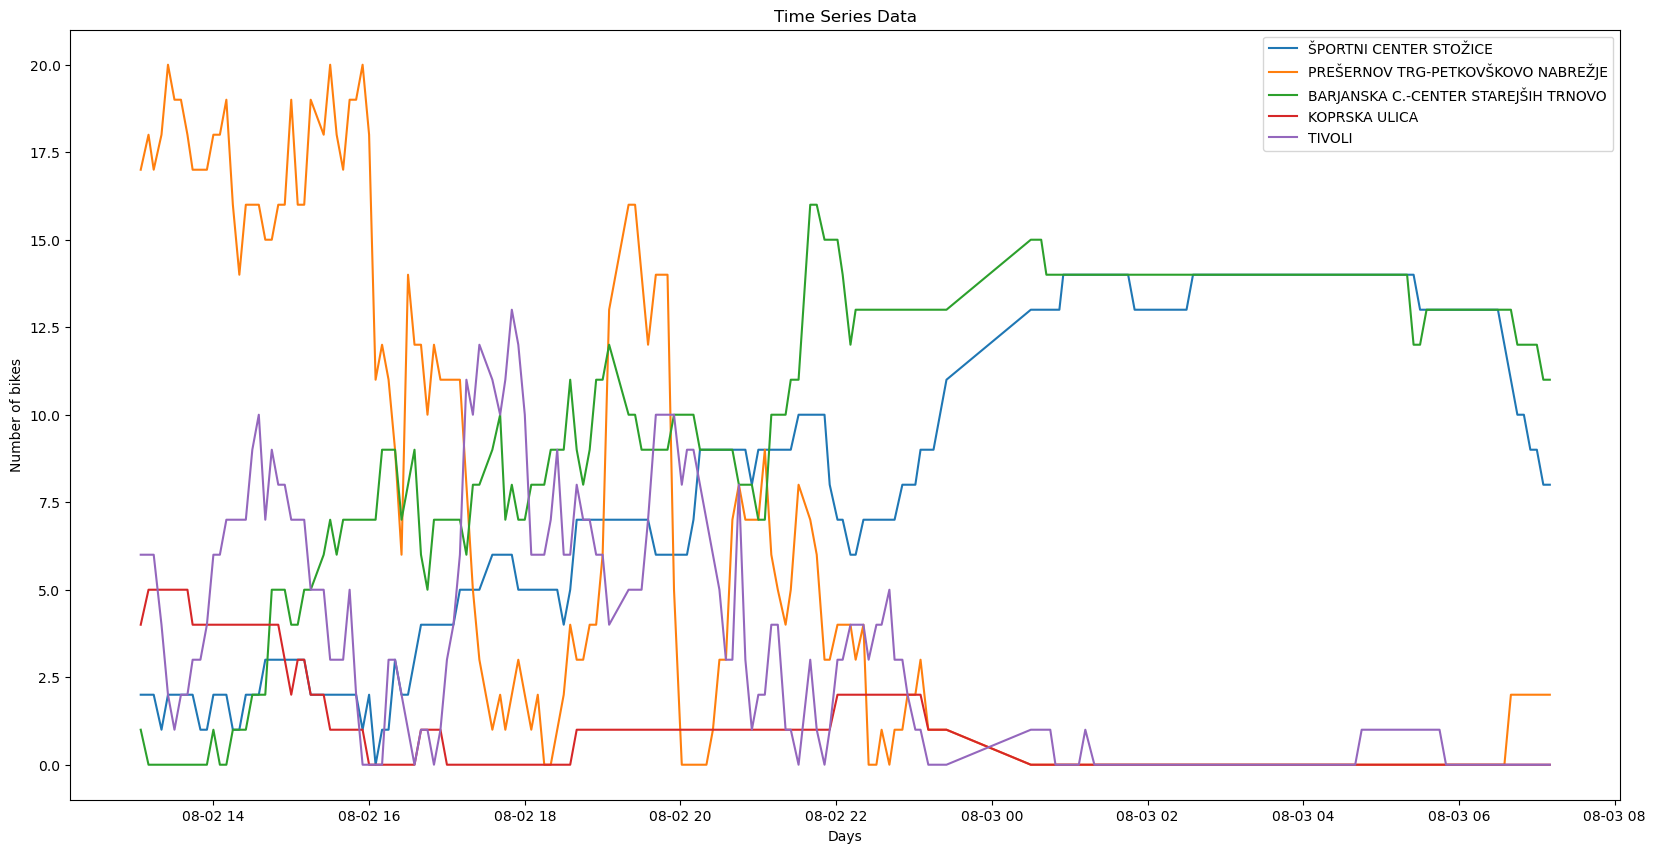

In [94]:
plot_bikes(train, n_stations=5, howmany=200)

In [95]:
# Extract new features
def get_time_based_features(timestamp):
    # From datetime64 get month, day, hour, dayOfWeek and isHoliday
    timestamp = np.datetime64(timestamp)
    dt_python = timestamp.astype(datetime.datetime)

    # Extract month, day, hour, and day_of_week
    month = dt_python.month
    day = dt_python.day
    hour = dt_python.hour
    minute = dt_python.minute
    day_of_week = dt_python.weekday()

    # Check for holidays
    is_holiday = 0
    if dt_python.month == 8 and dt_python.day in [15, 17]:
        is_holiday = 1
    elif dt_python.month == 9 and dt_python.day in [15, 23]:
        is_holiday = 1
   
    return month, day, hour, minute, day_of_week, is_holiday


In [96]:
# Get list of stations
stations = []
for i in range(1, 84):
    stations.append(train.columns[i])

In [97]:
# def get_shifted_rows(df, timestamp, timediff, station):
#     shifted_timestamp = timestamp - pd.DateOffset(hours=timediff)
#     shifted_row = df.loc[df['timestamp'] == shifted_timestamp, station]
#     return shifted_row.values[0] if not shifted_row.empty else 0

# for station in stations:
#     train[f"{station}_1hr"] = train.apply(lambda row: get_shifted_rows(train, row['timestamp'], 1, station), axis=1)
#     train[f"{station}_2hr"] = train.apply(lambda row: get_shifted_rows(train, row['timestamp'], 2, station), axis=1)


In [100]:
# train = pd.read_csv("data/processed_data.csv")
train.to_csv("data/processed_data.csv", index=False)

In [80]:
# Add new features to train
# train['month'], train['day'], train['hour'], train['minute'], train['day_of_week'], train['is_holiday'] = zip(*train['timestamp'].map(get_time_based_features))

In [81]:
# # One hot encode days of week and hours
# days_of_week = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]

# for i, day in enumerate(days_of_week):
#     train[day] = (train["day_of_week"] == i).astype(int)


# hours = [i for i in range(24)]
# for i in hours:
#     train[f"hour_{i}"] = (train["hour"] == i).astype(int)

In [82]:
# For test set
def find_closest_smaller_row(df, timestamp_col, target_row, hour_offset):
    target_timestamp = pd.to_datetime(target_row[timestamp_col]) - pd.DateOffset(hours=hour_offset)
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    smaller_rows = df[df[timestamp_col] < target_timestamp]
    if smaller_rows.empty:
        return None  # No smaller rows found
    closest_index = np.abs(smaller_rows[timestamp_col] - target_timestamp).idxmin()
    closest_row = df.loc[closest_index]
    return closest_row

c_row = find_closest_smaller_row(train, "timestamp", train.iloc[13], 1)

In [83]:
# train.head()
# train.to_csv("data/processed_data.csv", index=False)

In [84]:
# train.to_csv("data/processed_data.csv", index=False)

In [101]:
d = pd.read_csv("data/processed_data.csv")
ix = 1
for station in stations:
    if d.iloc[ix][station] - d.iloc[ix + 12][f'{station}_1hr'] != 0:
        print(f"{station} time: {d.iloc[ix]['timestamp']} - {d.iloc[ix + 12]['timestamp']}: n-bikes vs n_bikes_1hr {d.iloc[ix][station]} {d.iloc[ix + 12][f'{station}_1hr']}")

In [102]:
train = pd.read_csv("data/processed_data.csv")

# Drop first 25 rows
train = train.iloc[25:]

### Models and data
For each station, get the following columns:
- timestamp
- month
- day
- hour
- minute
- n_bikes_1h
- n_bikes_2h
- is_holiday
- day_of_week


In [21]:
# One hot encode day of week 
# train = pd.get_dummies(train, columns=['day_of_week'])

In [64]:
station_dataframes = {}

for station in stations:
    station_df = pd.DataFrame({
        "timestamp": train["timestamp"].values,
        "n_bikes": train[station].values,
        "month": train["month"].values,
        "day": train["day"].values,
        "hour": train["hour"].values,
        "minute": train["minute"].values,
        "day_of_week": train["day_of_week"].values,
        "is_holiday": train["is_holiday"].values,
        "n_bikes_1hr": train[f"{station}_1hr"].values,
        "n_bikes_2hr": train[f"{station}_2hr"].values
    })
    
    days_of_week = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]

    for i, day in enumerate(days_of_week):
        station_df[day] = train[day].values


    hours = [i for i in range(24)]
    for i in hours:
        station_df[f"hour_{i}"] = train[f"hour_{i}"].values    
    
    station_dataframes[station] = station_df
    
    station = station.replace("/", "_")
    station_df.to_csv(f"data/stations/{station}.csv", index=False)
    
    

In [ ]:
def model_test(X_test, y_test, model, loss_fn, epoch, test_losses: list = None):
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test.to(device))
        test_loss = loss_fn(test_pred, y_test.to(device))
        
        if epoch % 100 == 0:
            if test_losses is not None:
                test_losses.append(test_loss.cpu().numpy())
   
            print(f"Test loss: {test_loss.cpu().detach().numpy()}")
            
    return test_losses

# Training loop
def model_train(X_train, X_test, y_train, y_test, model, loss_fn, optimizer, epochs=10, epochs_list: list = None, train_losses: list = None, test_losses: list = None, scheduler=None):
    for epoch in range(epochs):
        model.train()   # Set mode
        
        # Forward pass and loss
        y_pred = model(X_train.to(device))
        train_loss = loss_fn(y_pred, y_train.to(device))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        test_losses = model_test(X_test, y_test, model, loss_fn, epoch, test_losses)
        
        if epoch % 100 == 0:
            train_losses.append(train_loss.cpu().detach().numpy())
            epochs_list.append(epoch)

            print(f"Epoch: {epoch}, Train loss: {train_loss.cpu().detach().numpy()}")
        if scheduler is not None:
            scheduler.step()
    return epochs_list, train_losses, test_losses
        

In [ ]:
presernov_df = station_dataframes[stations[0]]

X = presernov_df.drop(["timestamp", "n_bikes"], axis=1)
y = np.array(presernov_df["n_bikes"]).reshape((-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

n_epochs = 10000

X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

# y_train = y_train.unsqueeze(1)
# y_test = y_test.unsqueeze(1)

# Element-wise multiplication
# y_train = torch.mul(X_train, y_train)
# y_test = torch.mul(X_test, y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([6171, 8]),
 torch.Size([6171, 1]),
 torch.Size([1543, 8]),
 torch.Size([1543, 1]))

Removed month
Removed day
Removed day_of_week
Removed is_holiday
23.65634718033575


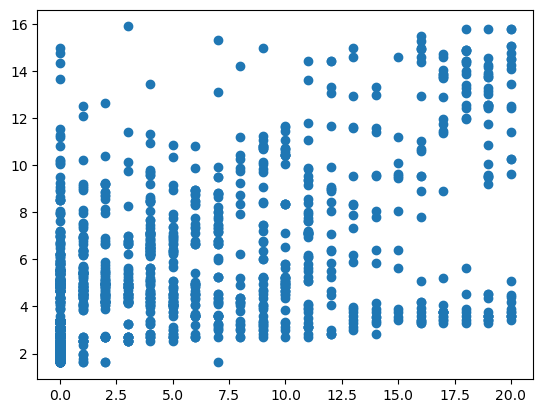

In [ ]:

def linear_regression(X_train, X_test, y_train, y_test):
        # Fit model
    lr = linear_model.Lasso()
    # lr = Lasso(alpha=1)
    lr.fit(X_train, y_train)
    
    coefs = lr.coef_
    
    for i in range(len(coefs)):
        if coefs[i] == 0:
            print(f"Removed {X.columns[i]}")
        # else:
        #     print(f"{(X[i])}: {lr.coef_[i]}")
    
    # Predict and score
    y_pred = lr.predict(X_test)
    
    plt.scatter(y_test, y_pred)
    
    score = mean_squared_error(y_test, y_pred)
    return lr, score

lr, score = linear_regression(X_train, X_test, y_train, y_test)
print(score)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(X_train, X_test, y_train, y_test):
        # Fit model
    rf = RandomForestRegressor()
    # lr = Lasso(alpha=1)
    rf.fit(X_train, y_train)

    # Predict and score
    y_pred = rf.predict(X_test)
    
    plt.scatter(y_test, y_pred)
    
    score = mean_squared_error(y_test, y_pred)
    return rf, score

In [ ]:
y_train

tensor([[16.],
        [19.],
        [18.],
        ...,
        [13.],
        [10.],
        [14.]])

20.64189481529488

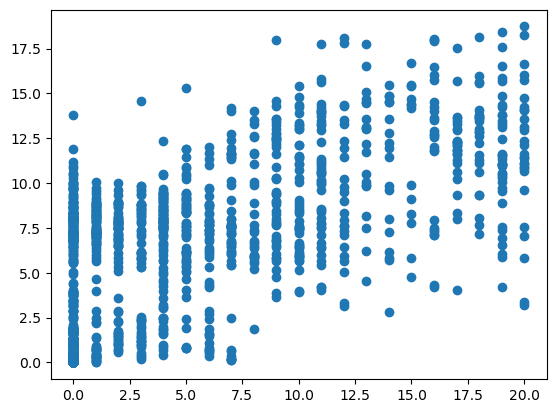

In [ ]:
rf, score = random_forest(X_train, X_test, y_train, y_test)
# plt.bar(len(rf.feature_importances_), rf.feature_importances_)
score

In [ ]:
# For each station get prediction for each timestamp and save to csv - note: don't forget to get the extra features

In [ ]:
X.shape, y.shape

((7714, 8), (7714, 1))

In [ ]:
# Train model for a single station
presernov_model = LinearRegression(X.shape[1], y.shape[1])

In [ ]:
lr = 1e-5
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(presernov_model.parameters(), lr=lr)
n_epochs = 10000
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=.4+)

In [ ]:
train_losses, test_losses, epochs = [], [], []

epochs, train_losses, test_losses = model_train(X_train, X_test, y_train, y_test, presernov_model, loss_fn, optimizer, n_epochs, epochs, train_losses, test_losses)


Test loss: 23.70608139038086
Epoch: 0, Train loss: 24.738100051879883
Test loss: 23.705852508544922
Epoch: 100, Train loss: 24.73807716369629
Test loss: 23.70563507080078
Epoch: 200, Train loss: 24.738052368164062
Test loss: 23.705427169799805
Epoch: 300, Train loss: 24.73802947998047
Test loss: 23.705224990844727
Epoch: 400, Train loss: 24.738008499145508
Test loss: 23.70503807067871
Epoch: 500, Train loss: 24.737985610961914
Test loss: 23.70485496520996
Epoch: 600, Train loss: 24.73796272277832
Test loss: 23.704683303833008
Epoch: 700, Train loss: 24.737943649291992
Test loss: 23.70451545715332
Epoch: 800, Train loss: 24.73792266845703
Test loss: 23.7043514251709
Epoch: 900, Train loss: 24.737899780273438
Test loss: 23.70419692993164
Epoch: 1000, Train loss: 24.73788070678711
Test loss: 23.70404624938965
Epoch: 1100, Train loss: 24.73785972595215
Test loss: 23.703899383544922
Epoch: 1200, Train loss: 24.737838745117188
Test loss: 23.70375633239746
Epoch: 1300, Train loss: 24.73781585

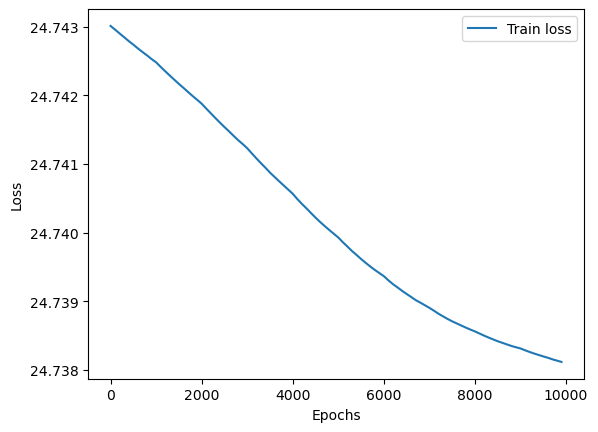

In [ ]:
plot_loss(epochs, train_losses)

In [ ]:
with torch.inference_mode():
    y_pred = presernov_model(X_test[:, 0].to(device))
    print(y_pred.shape)
    # print(y_pred.cpu())
    print(y_pred.cpu().detach().numpy().shape)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
        
    ax[0].plot(X_test[:, 0], y_pred.cpu().detach().numpy(), label="Predicted")
    ax[1].plot(X_test[:, 0], y_test.cpu().detach().numpy(), label="Real")
    ax[0].legend(), ax[1].legend()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1543 and 8x1)